# Hard Drive Failure Prediction in the Data Center


## Stage 2: Remaining Useful Life (RUL) Estimation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import pickle

from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, adadelta, adam

#set matplotlib parameters
%matplotlib inline
sns.set_style('white')
plt.rcParams['axes.grid'] = True
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['grid.color'] = 'k'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

Using TensorFlow backend.


### Import Data

In [2]:
def import_data(quarters, model, columns):
    """ Import hard drive data from csvs on disk.
    
    :param quarters: List of quarters to import (e.g., 1Q19, 4Q18, 3Q18, etc.)
    :param model: String of the hard drive model number to import.
    :param columns: List of the columns to import.
    :return: Dataframe with hard drive data.
    
    """
    
    cwd = os.getcwd()
    df = pd.DataFrame()
    
    for q in quarters:
        data = pd.concat([pd.read_csv(f, header=0, usecols=columns, parse_dates=['date']) for f in glob.glob(cwd + '/data/' + q + '/*.csv')], ignore_index=True)
        data = data[data.model == model]
        data.drop(columns=['model'], inplace=True)
        data.failure = data.failure.astype('int')
        data.smart_9_raw = data.smart_9_raw / 24.0 # convert power-on hours to days
        df = pd.concat([df, data])
        
    df.reset_index(inplace=True, drop=True)
    df = df.set_index(['serial_number', 'date']).sort_index()
    
    return df

In [3]:
# load data
cwd = os.getcwd()
with open(cwd + '/data/columns_to_keep.pkl', 'rb') as file:
    columns = pickle.load(file)

quarters = ['1Q19', '4Q18', '3Q18', '2Q18', '1Q18', '4Q17'] # train and test on 18 months of data
model = 'ST4000DM000'

df = import_data(quarters=quarters, model=model, columns=columns)
df.head()

failure  smart_1_raw  smart_4_raw  smart_5_raw  \
serial_number date                                                         
S3000A9T      2017-10-01        0  237619512.0         34.0          0.0   
              2017-10-02        0   49638784.0         34.0          0.0   
              2017-10-03        0   91364776.0         34.0          0.0   
              2017-10-04        0  136407160.0         34.0          0.0   
              2017-10-05        0  203167736.0         34.0          0.0   

                          smart_7_raw  smart_9_raw  smart_12_raw  \
serial_number date                                                 
S3000A9T      2017-10-01  111775903.0   150.041667          28.0   
              2017-10-02  111837327.0   151.041667          28.0   
              2017-10-03  111896388.0   152.041667          28.0   
              2017-10-04  111962617.0   153.125000          28.0   
              2017-10-05  112028214.0   154.125000          28.0   

                          smart_187_raw  smart_188_raw  smart_190_raw  \
serial_number date                                                      
S3000A9T      2017-10-01            0.0            0.0           28.0   
              2017-10-02            0.0            0.0           28.0   
              2017-10-03            0.0            0.0           26.0   
              2017-10-04            0.0            0.0           28.0   
              2017-10-05            0.0            0.0           28.0   

                          smart_192_raw  smart_193_raw  smart_194_raw  \
serial_number date                                                      
S3000A9T      2017-10-01            0.0        52173.0           28.0   
              2017-10-02            0.0        53166.0           28.0   
              2017-10-03            0.0        54384.0           26.0   
              2017-10-04            0.0        55703.0           28.0   
              2017-10-05            0.0        56376.0           28.0   

                          smart_197_raw  smart_198_raw  smart_199_raw  \
serial_number date                                                      
S3000A9T      2017-10-01            0.0            0.0            0.0   
              2017-10-02            0.0            0.0            0.0   
              2017-10-03            0.0            0.0            0.0   
              2017-10-04            0.0            0.0            0.0   
              2017-10-05            0.0            0.0            0.0   

                          smart_240_raw  smart_241_raw  smart_242_raw  
serial_number date                                                     
S3000A9T      2017-10-01         3188.0   1.029309e+10   9.981613e+09  
              2017-10-02         3209.0   1.029320e+10   1.001598e+10  
              2017-10-03         3228.0   1.029330e+10   1.004660e+10  
              2017-10-04         3250.0   1.029342e+10   1.008192e+10  
              2017-10-05         3271.0   1.029353e+10   1.011147e+10

### Preprocessing

#### Filter HDs with short powered-on time, and too many missing values.

In [4]:
def filter_HDs(df, min_days, time_window, tolerance):
    """ Find HDs with an excessive amount of missing values.
    
    :param df: Input dataframe.
    :param min_days: Minimum number of days HD needs to have been powered on.
    :param time_window: Size of window to count missing values (e.g., 7 days as '7D', or five days as '5D')
    :param tolerance: Maximum number of days allowed to be missing within time window.
    :return: List of HDs with excessive amount of missing values
    
    """
    
    bad_power_hds = []
    for serial_num, inner_df in df.groupby(level=0): # identify HDs with too few power-on days.
        if len(inner_df) < min_days:
            bad_power_hds.append(serial_num)
        else:
            pass
        
    bad_missing_hds = []
    for serial_num, inner_df in df.groupby(level=0): # indentify HDs with too many missing values.
        inner_df = inner_df.droplevel(level=0)
        inner_df = inner_df.asfreq('D')
        n_missing = max(inner_df.isna().rolling(time_window).sum().max())

        if n_missing >= tolerance:
            bad_missing_hds.append(serial_num)
        else:
            pass
    
    return bad_missing_hds, bad_power_hds


In [5]:
# drop bad HDs
bad_missing_hds, bad_power_hds = filter_HDs(df, min_days = 30, time_window='7D', tolerance=7)
bad_hds = set(bad_missing_hds + bad_power_hds)

hds_remove = len(bad_hds)
hds_total = len(df.reset_index().serial_number.unique())
print('Total HDs: {}    HDs removed: {} ({}%)'.format(hds_total, hds_remove, round(hds_remove/hds_total * 100, 2)))

df = df.drop(bad_hds, axis=0)

Total HDs: 33361    HDs removed: 1010 (3.03%)


In [6]:
# What percent of hard drives in use failed?
num_fail = df.failure.sum()
num_not_fail = len(df.reset_index().serial_number.unique()) - num_fail
pct_fail = num_fail / (num_not_fail + num_fail) * 100 

print('{} failed'.format(num_fail))
print('{} did not fail'.format(num_not_fail))
print('{:5f}% failed'.format(pct_fail))

847 failed
31504 did not fail
2.618157% failed


#### Balance the dataset via downsampling.

In [7]:
def downsample(df):
    """ Downsample the hard drives that did not fail, and return lists of failed and not failed hard drives.
    
    :param df: Input dataframe.
    :return: returns downsampled dataframe, as well as failed, and not failed lists of hard drive serial numbers.
    """
    
    # generate lists of hard drives failed & not failed
    failed = [h[0] for h in list(df[df.failure == 1].index)]
    failed = list(set(failed)) # unique list of all drives that failed

    not_failed = [h[0] for h in list(df.index) if h[0] not in failed]
    not_failed = list(set(not_failed)) # unique list of all drives that did not fail

    # random downsampling of not-failed 
    np.random.seed(0)
    not_failed = np.random.choice(not_failed, size=len(failed), replace=False)
    not_failed = list(not_failed)

    to_keep = not_failed + failed
    df = df.loc[to_keep]
    
    return df, failed, not_failed
    

In [8]:
df, failed, not_failed = downsample(df)
print('Number of failed HDs: {}.'.format(len(failed)))


Number of failed HDs: 845.


#### Interpolate missing time series values.

In [9]:
def interpolate_ts(df, method='linear'):
    
    """ Interpolate hard drive Smart attribute time series.
    
    :param df: Input dataframe.
    :param method: String, interpolation method.
    :return: Dataframe with interpolated values.
    """
    
    interp_df = pd.DataFrame()

    for serial_num, inner_df in df.groupby(level=0):
        inner_df = inner_df.droplevel(level=0)
        inner_df = inner_df.asfreq('D') 
        inner_df.interpolate(method=method, axis=0, inplace=True)
        inner_df['serial_number'] = serial_num
        inner_df = inner_df.reset_index()

        interp_df = pd.concat([interp_df, inner_df], axis=0)

    df = interp_df.set_index(['serial_number', 'date']).sort_index()
    
    return df


In [10]:
method = 'linear'
df = interpolate_ts(df, method=method)


#### Remaining Useful Life (RUL) target function.

In [11]:
def RUL_target(df, MUL, degradation):
    """Calculate two Remaining Useful Life (RUL) Target Functions, linear and piecewise.
    
    :param df: Dataframe to calculate and append RUL functions.
    :param MUL: Maximum useful life of the hard drive model.
    :param degradation: The number of time-steps before hard drive degradation becomes observable. 
    :return: RUL function.
    """
    
    RUL_list = []
    RUL_pw_list = []
    max_RUL = MUL - degradation
    
    for serial_num, inner_df in df.groupby(level=0):
        slicer_val = len(inner_df) * -1 # save len(df) to use as slicer value on smooth_smart_9 
        smooth_smart_9 = inner_df.smart_9_raw.max().round() # get max smart_9_raw for smoothing
        
        while smooth_smart_9 < len(inner_df): # had to add while loop to increase smooth_smart_9 max due to messy smart_9_raw values
            smooth_smart_9 += 1
            
        smooth_smart_9 = list(range(int(smooth_smart_9) + 1)) # smoothly incrementing smart_9_raw
        smooth_smart_9 = smooth_smart_9[slicer_val:] # only keep the values that match the length of the inner_df
        
        if inner_df.failure.max() == 1:
            TUL = max(smooth_smart_9) # total useful life
        else:
            TUL = MUL # total useful life
        
        RUL = TUL - np.array(smooth_smart_9) # linear RUL
        RUL_pw = [min(r, max_RUL) for r in RUL] # piecewise RUL
    
        RUL_list.append(RUL)
        RUL_pw_list.append(RUL_pw)
    
    RUL_list = [item for array in RUL_list for item in array] # unpack arrays in RUL_list... human readability: start from first 'for' statement. 
    RUL_pw_list = [item for array in RUL_pw_list for item in array] # unpack arrays in RUL_pw_list
    
    return RUL_pw_list
    

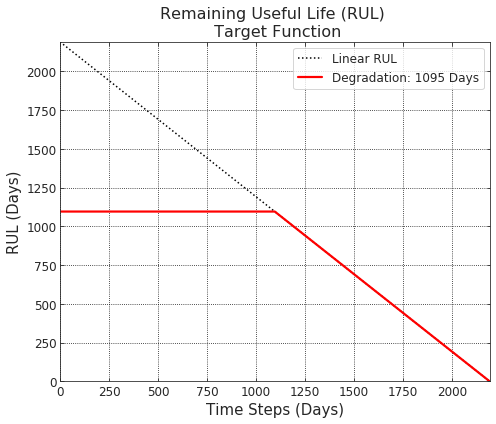

failure  smart_1_raw  smart_4_raw  smart_5_raw  \
serial_number date                                                         
S3006MB6      2017-10-01      0.0   95885576.0         16.0          0.0   
              2017-10-02      0.0  127690976.0         16.0          0.0   
              2017-10-03      0.0  104747272.0         16.0          0.0   
              2017-10-04      0.0  120810448.0         16.0          0.0   
              2017-10-05      0.0   69840144.0         16.0          0.0   

                          smart_7_raw  smart_9_raw  smart_12_raw  \
serial_number date                                                 
S3006MB6      2017-10-01  548171726.0  1300.916667          16.0   
              2017-10-02  549072838.0  1301.958333          16.0   
              2017-10-03  549934661.0  1302.916667          16.0   
              2017-10-04  550651336.0  1303.750000          16.0   
              2017-10-05  551879778.0  1304.750000          16.0   

                          smart_187_raw  smart_188_raw  smart_190_raw  ...  \
serial_number date                                                     ...   
S3006MB6      2017-10-01            0.0            0.0           24.0  ...   
              2017-10-02            0.0            0.0           24.0  ...   
              2017-10-03            0.0            0.0           25.0  ...   
              2017-10-04            0.0            0.0           24.0  ...   
              2017-10-05            0.0            0.0           23.0  ...   

                          smart_193_raw  smart_194_raw  smart_197_raw  \
serial_number date                                                      
S3006MB6      2017-10-01       141428.0           24.0            0.0   
              2017-10-02       141428.0           24.0            0.0   
              2017-10-03       141428.0           25.0            0.0   
              2017-10-04       141428.0           24.0            0.0   
              2017-10-05       141438.0           23.0            0.0   

                          smart_198_raw  smart_199_raw  smart_240_raw  \
serial_number date                                                      
S3006MB6      2017-10-01            0.0            0.0        30640.0   
              2017-10-02            0.0            0.0        30664.0   
              2017-10-03            0.0            0.0        30688.0   
              2017-10-04            0.0            0.0        30708.0   
              2017-10-05            0.0            0.0        30732.0   

                          smart_241_raw  smart_242_raw  RUL_pw  RUL_yesterday  
serial_number date                                                             
S3006MB6      2017-10-01   2.069188e+10   1.314767e+11     889          890.0  
              2017-10-02   2.069432e+10   1.315128e+11     888          889.0  
              2017-10-03   2.069666e+10   1.315552e+11     887          888.0  
              2017-10-04   2.069865e+10   1.315857e+11     886          887.0  
              2017-10-05   2.070174e+10   1.316311e+11     885          886.0  

[5 rows x 21 columns]

In [12]:
# generate RUL piecewise target
MUL = 2190
degradation = 1095
RUL_cap = MUL - degradation
df['RUL_pw'] = RUL_target(df, MUL=MUL, degradation=degradation) # define RUL piecewise

# RUL yesterday used for model training
RUL_yest_list = []
for serial_num, inner_df in df.groupby(level=0):
    RUL_yesterday = inner_df.RUL_pw.shift(periods=1)
    RUL_yesterday[0] = RUL_yesterday[1] + (RUL_yesterday[1] - RUL_yesterday[2])
    RUL_yest_list.append(RUL_yesterday)
    
RUL_yest_list = [item for array in RUL_yest_list for item in array]
df['RUL_yesterday'] = RUL_yest_list

# plot RUL target functions
xs = list(np.linspace(0, MUL, MUL + 1))
ys = list(np.linspace(MUL, 0, MUL + 1))

ys_1460 = [min(y, MUL - 1460) for y in ys]
ys_1095 = [min(y, MUL - 1095) for y in ys]
ys_730 = [min(y, MUL - 730) for y in ys]

#plot RUL target function
plt.figure(figsize=(7, 6))
plt.plot(xs, ys, color='k', linestyle=':')
#plt.plot(xs, ys_730, color='blue', linewidth=2.2)
plt.plot(xs, ys_1095, color='red', linewidth=2.2)
#plt.plot(xs, ys_1460, color='orange', linewidth=2.2)
plt.xlim(0, MUL)
plt.ylim(0, MUL)
plt.xlabel('Time Steps (Days)')
plt.ylabel('RUL (Days)')
plt.legend(['Linear RUL', 'Degradation: 1095 Days'], prop={'size':12})
plt.title('Remaining Useful Life (RUL) \n Target Function', size=16)
plt.tight_layout()
plt.savefig(cwd + '/figures/RUL_target.png')
plt.show()
df.head()

#### Feature Analysis


In [13]:
def hard_drive_ages(serial_numbers, examples=True):
    """ Find the ages and examples of young, average, and old hard drives.
    
    :param serial_numbers: the list of serial numbers to find ages for.
    :param examples: If 'True', return the serial numbers of young, average, and old examples of hard drives.
    :return: Dataframe of hard drive serial numbers as index, and ages as values.
    
    """
    hd_ages = {}
    for serial_num, inner_df in df.loc[serial_numbers].groupby(level=0):
        age = inner_df.smart_9_raw.max()
        hd_ages[serial_num] = age
        
    hd_ages = pd.Series(hd_ages).reset_index()
    hd_ages.columns = ['serial_number', 'age']
    
    if examples == True:
        
        hd_ages = hd_ages.sort_values('age').reset_index(drop=True)
        increment = int(round(len(hd_ages) * .32))
        
        yng = list(hd_ages.iloc[increment:increment + 5, :]['serial_number'])
        avg = list(hd_ages.iloc[increment * 2:increment * 2 + 5, :]['serial_number'])
        old = list(hd_ages.iloc[increment * 3:increment * 3 + 5, :]['serial_number'])
    
    return hd_ages, yng, avg, old


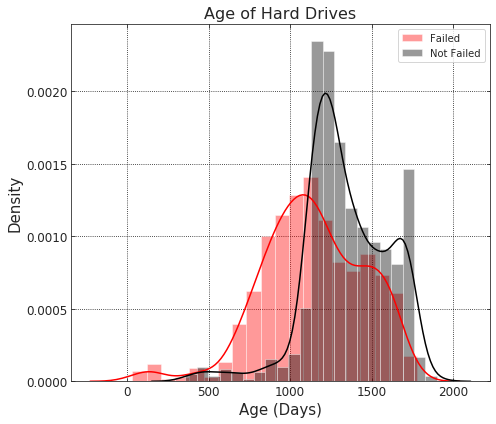

In [14]:
# get hard drive ages for failed and not failed
failed_hd_ages, yng_failed, avg_failed, old_failed = hard_drive_ages(failed)
not_failed_hd_ages, yng_not_failed, avg_not_failed, old_not_failed = hard_drive_ages(not_failed)

plt.figure(figsize=(7, 6))
sns.distplot(failed_hd_ages.age, color='red', label='Failed')
sns.distplot(not_failed_hd_ages.age, color='k', label='Not Failed')

plt.xlabel('Age (Days)')
plt.ylabel('Density')
plt.legend()
plt.title('Age of Hard Drives', size=16)

plt.tight_layout()
plt.show()

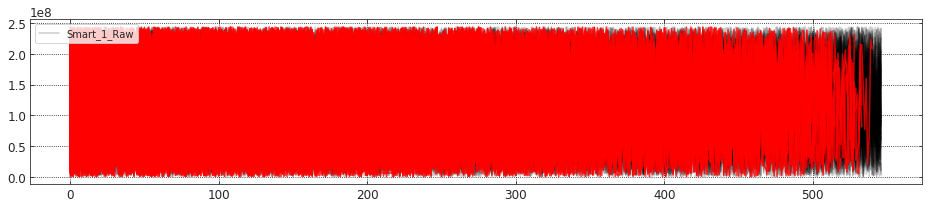

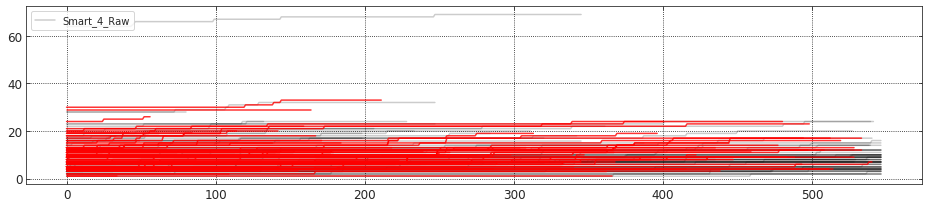

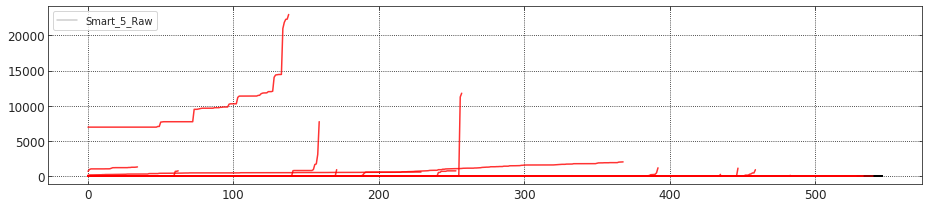

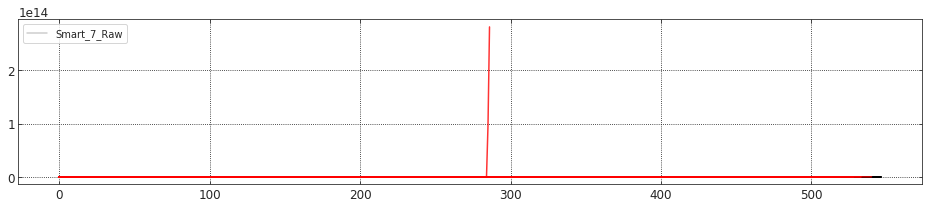

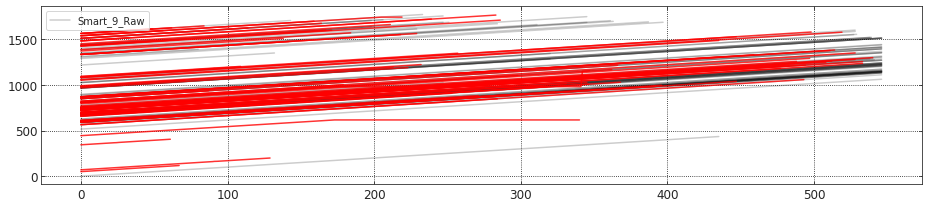

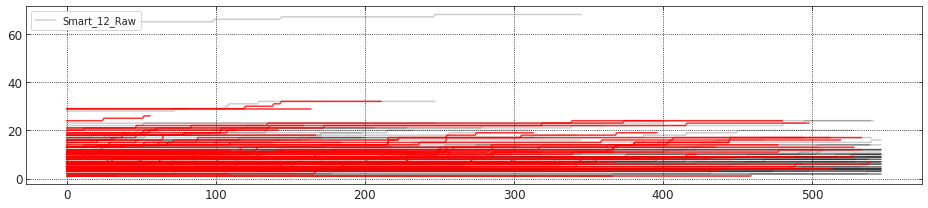

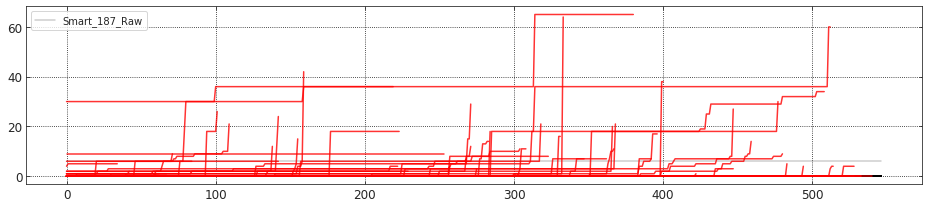

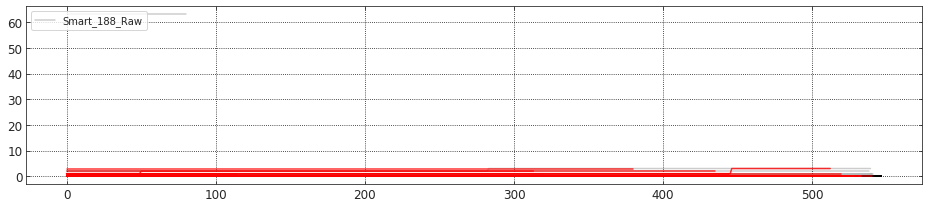

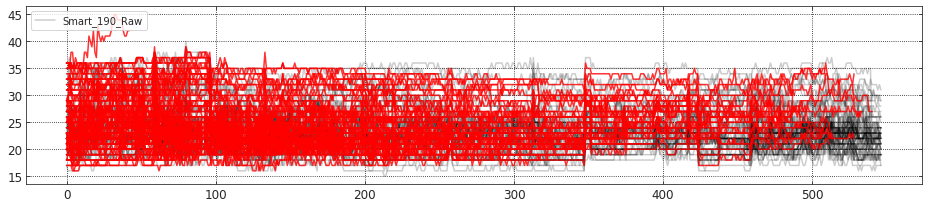

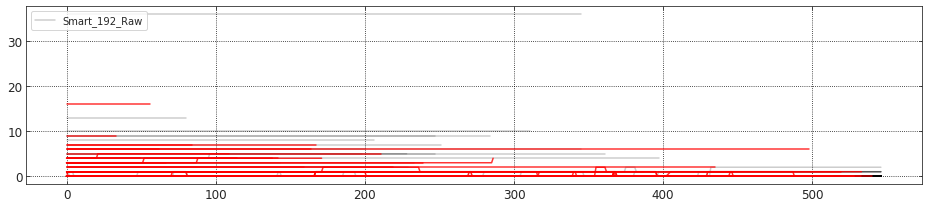

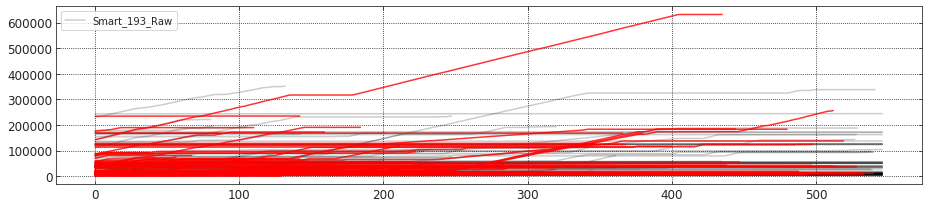

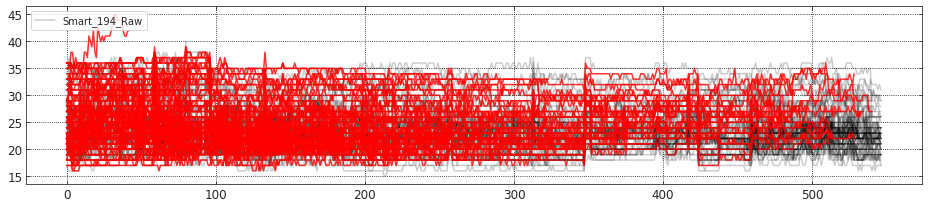

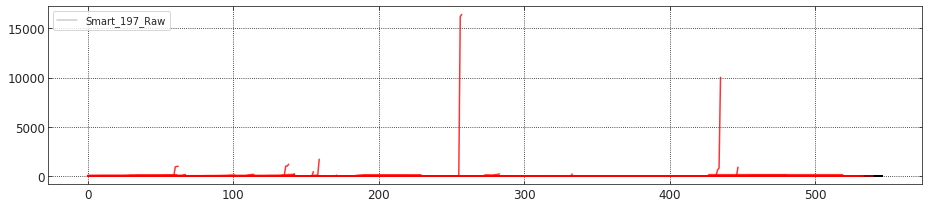

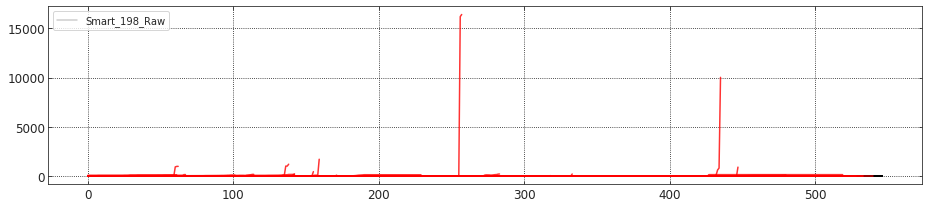

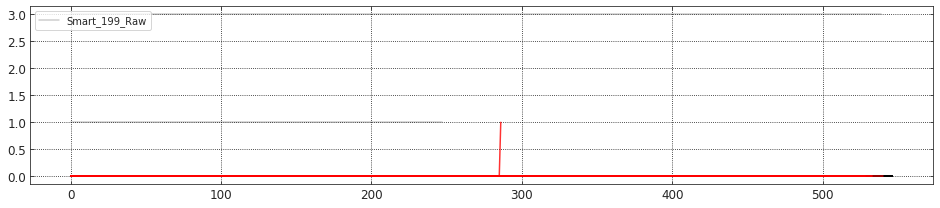

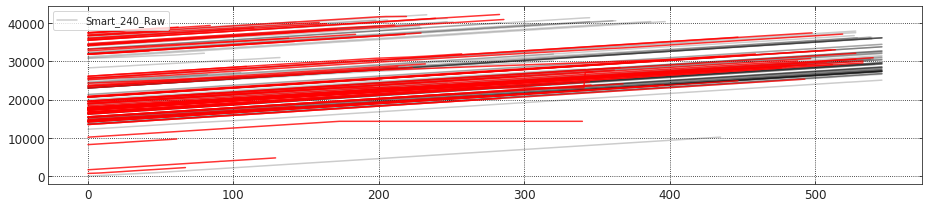

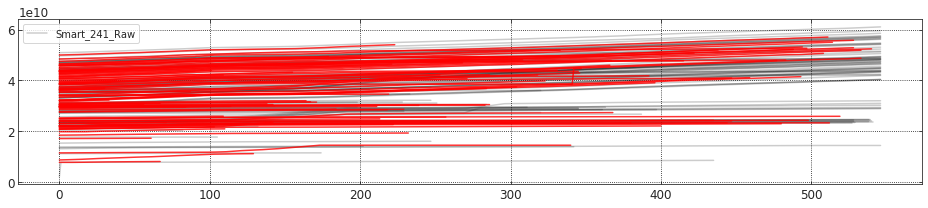

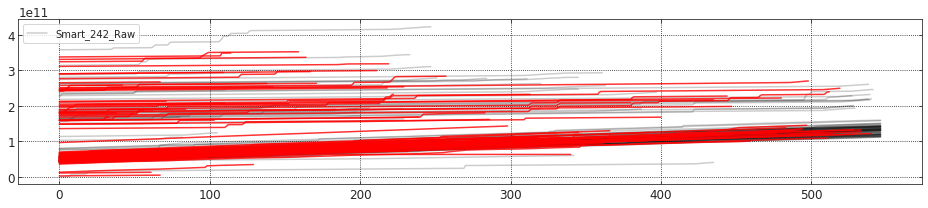

In [15]:
np.random.seed(42)
f_to_plot = np.random.choice(failed, size=100, replace=False)
nf_to_plot = np.random.choice(not_failed, size=100, replace=False)

for col in list(df.columns):
    if col.startswith('smart'):
        plt.figure(figsize=(13, 3))

        for hd in nf_to_plot:
            plt.plot(df.loc[hd, col].values, color='k', alpha=0.2, linewidth=1.5)

        for hd in f_to_plot:
            plt.plot(df.loc[hd, col].values, color='red', alpha=0.8)

        plt.legend([col.title()], loc=2)
        #plt.title(col.title(), size=16)
        plt.tight_layout()
        plt.show()
    else:
        pass 
    

#### Scale

In [16]:
# scale each feature by its maximum value, so that each feature value is between 0 and 1
mms = MinMaxScaler(feature_range=(0, 1))

RULs = df.loc[:, ['RUL_pw', 'RUL_yesterday']] / RUL_cap
df = df.drop(columns=['RUL_pw', 'RUL_yesterday'], axis=1)

df = pd.DataFrame(mms.fit_transform(df), columns= df.columns, index=df.index)

df[['RUL_pw', 'RUL_yesterday']] = RULs
df['delta_RUL'] = df.RUL_pw - df.RUL_yesterday # Define target for prediction, i.e., change in RUL from one day to the next

#### Feature Assessment

Feature relevance may already be well known to some specialists or domain experts in the field, however, for our purpose we identify features based on statistical significance without prior information in order to validate techniques in areas that do not have specialists or domain experts. 

In [17]:
# define train and test sets while taking into account whether the drive failed or not
np.random.seed(0)

# generate list of failed HDs for test
test_failed = list(np.random.choice(failed, size=int(len(failed) * 0.05)))
test_not_failed = list(np.random.choice(not_failed, size=int(len(not_failed) * 0.05)))
test = test_failed + test_not_failed 

# make sure there is a variety of ages for testing and plotting
for_plotting =  yng_failed + avg_failed + old_failed + yng_not_failed + avg_not_failed + old_not_failed 
test = list(set(test + for_plotting))

# generate list of not failed HDs for test
train = failed + not_failed # set train as full list of available HDs
train = list(filter(lambda x: x not in test, train)) # filter HDs that will be used for testing

# create train dataframe and ytrain
df_train = df.loc[train, :].sort_index()
ytrain = df_train.delta_RUL.values
df_train = df_train.drop(columns=['failure', 'RUL_pw', 'delta_RUL'], axis=1)

# create test dataframe, ytest... Xtest will be built during in the model forecasting step
df_test = df.loc[test, :].sort_index()
ytest = df_test.delta_RUL.values

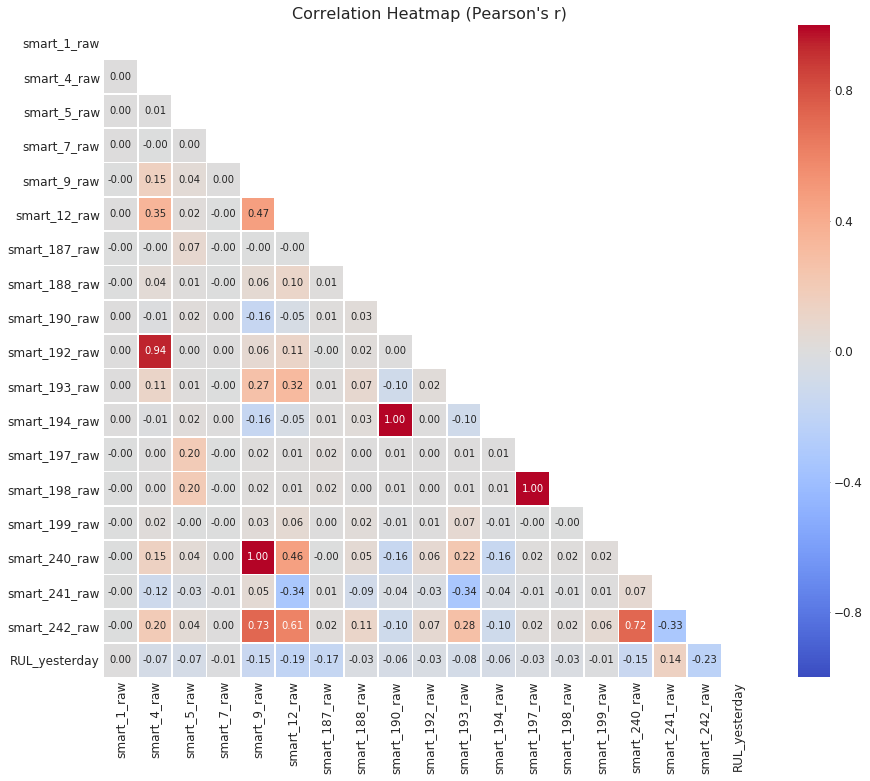

In [18]:
corr = df_train.corr()
np.zeros_like(corr)
mask = np.triu(corr)

plt.figure(figsize=(15, 12))
sns.heatmap(data=corr, cmap='coolwarm', vmin=-1.0, vmax=1.0, linewidths=0.6, mask=mask, square=True, annot=True, fmt='0.2f')
plt.tick_params(length=0)
plt.title('Correlation Heatmap (Pearson\'s r)', size=16)
plt.show()

In [19]:
# drop redundant variables
corr_vars = ['smart_192_raw', 'smart_194_raw', 'smart_198_raw', 'smart_240_raw']
df_train = df_train.drop(columns=corr_vars)


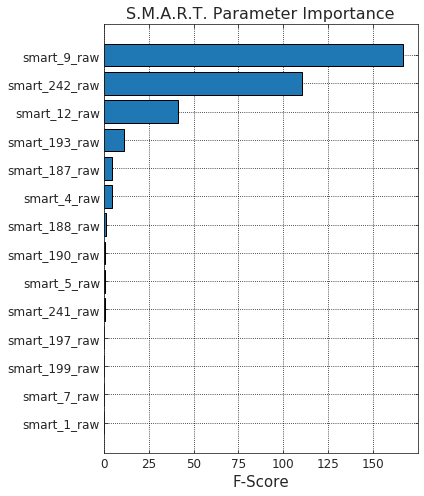

In [20]:
features = df_train.drop(columns='RUL_yesterday').columns

# univariate importance
fs, p = f_regression(StandardScaler().fit_transform(df_train.drop(columns='RUL_yesterday').values), ytrain)
feat_imps = pd.Series(dict(zip(features, fs / 1000))).sort_values()

# plot feature importances and coefficients
fig, ax = plt.subplots(figsize=(6, 7))

ax.barh(feat_imps.index, feat_imps, edgecolor='k')
ax.set_xlabel('F-Score')
ax.set_title('S.M.A.R.T. Parameter Importance', size=16)
plt.savefig(cwd + '/figures/feature_importance.png')
plt.tight_layout()
plt.show()


In [21]:
# drop most irrelevant features
irr_vars = ['smart_1_raw','smart_7_raw','smart_197_raw', 'smart_199_raw']
df_train = df_train.drop(columns=irr_vars)
to_drop = corr_vars + irr_vars

# Xtrain 
Xtrain = df_train.values

### Model Optimization

#### Random Forest Regressor (RFR)


In [ ]:
#parameters to test
n_estimators = [100, 300, 500, 700]
min_samples_leaf = [1, 3, 5, 10, 15]

#gridsearchcv
parameters = {'n_estimators':n_estimators, 'min_samples_leaf':min_samples_leaf}
rfr = RandomForestRegressor(random_state=0, max_features='sqrt')
grd_rfr = GridSearchCV(rfr, param_grid=parameters, cv=5, return_train_score=True)
grd_rfr.fit(Xtrain, ytrain)


In [22]:
rfr_opt = RandomForestRegressor(n_estimators=500, min_samples_leaf=3, max_features='sqrt', oob_score=True)
rfr_opt.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

#### Gradient Boosting Regressor (GBR)

In [ ]:
#parameters to test
n_estimators = [300, 500, 700, 1000]
learning_rate = [0.01, 0.1, 1.0]
min_samples_leaf = [1, 3, 5, 10]

#gridsearchcv
parameters = {'n_estimators':n_estimators, 'learning_rate':learning_rate, 'min_samples_leaf':min_samples_leaf}
gbr = GradientBoostingRegressor(random_state=0, max_features='sqrt')
grd_gbr = GridSearchCV(gbr, param_grid=parameters, cv=5, return_train_score=True)
grd_gbr.fit(Xtrain, ytrain)


In [23]:
gbr_opt = GradientBoostingRegressor(n_estimators=700, learning_rate=0.1, min_samples_leaf=5, max_features='sqrt')
gbr_opt.fit(Xtrain, ytrain)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=700,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

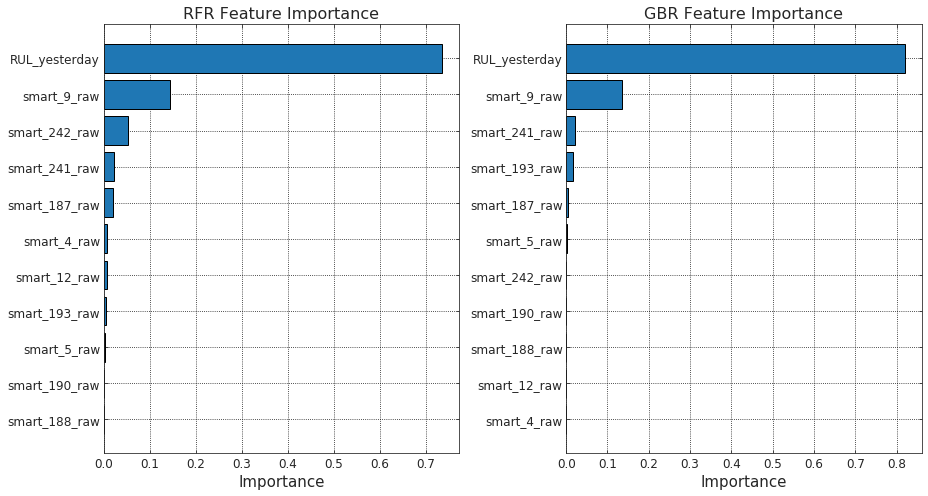

In [24]:
gbr_importances = list(gbr_opt.feature_importances_)
rfr_importances = list(rfr_opt.feature_importances_)
features = (df_train.columns)

gbr_feat_imps = pd.Series(dict(zip(features, gbr_importances))).sort_values()
rfr_feat_imps = pd.Series(dict(zip(features, rfr_importances))).sort_values()

fig, ax = plt.subplots(1, 2, figsize=(13, 7))
ax[0].barh(rfr_feat_imps.index, rfr_feat_imps, edgecolor='k')
ax[0].set_xlabel('Importance')
ax[0].set_title('RFR Feature Importance', size=16)

ax[1].barh(gbr_feat_imps.index, gbr_feat_imps, edgecolor='k')
ax[1].set_xlabel('Importance')
ax[1].set_title('GBR Feature Importance', size=16)

plt.tight_layout()
plt.show()

####  1D Convolutional Neural Network (1D CNN) Regressor

In [24]:
def reshape(array):
    """Reshape array for input to CNN."""
    
    data = []
    
    for obs in array:
        data.append(obs.reshape(11, 1))
        
    data = np.array(data)
    
    return data
        

In [25]:
Xtrain_temp = reshape(Xtrain)

Xtrain_cnn, X_valid, ytrain_cnn, y_valid = train_test_split(Xtrain_temp, ytrain, test_size=0.10, shuffle=True, random_state=0)

In [26]:
#1D CNN parameters
shape = (11, 1)
kernel_size = 2
stride = 1

#optimizer = SGD(lr=0.01, momentum=0.001, decay=0.0001, nesterov=True)
optimizer = adam(lr=0.0008, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0005)
#optimizer = adadelta()

#1D CNN
cnn_1D = Sequential()

cnn_1D.add(Conv1D(15, kernel_size=kernel_size, strides=stride, padding='same', data_format='channels_last', input_shape=shape))
cnn_1D.add(Activation('tanh'))

cnn_1D.add(Conv1D(10, kernel_size=kernel_size, strides=stride, padding='same'))
cnn_1D.add(MaxPooling1D())
cnn_1D.add(Activation('tanh'))

cnn_1D.add(Conv1D(10, kernel_size=kernel_size, strides=stride, padding='same'))
cnn_1D.add(MaxPooling1D())
cnn_1D.add(Activation('relu'))

#cnn_1D.add(Conv1D(8, kernel_size=kernel_size, strides=stride, padding='same'))
#cnn_1D.add(MaxPooling1D())
#cnn_1D.add(Activation('tanh'))

cnn_1D.add(Flatten())
cnn_1D.add(Dense(1, activation='linear'))

cnn_1D.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])
print(cnn_1D.summary())


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 11, 15)            45        
_________________________________________________________________
activation_1 (Activation)    (None, 11, 15)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 10)            310       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 10)             0         
_________________________________________________________________
activation_2 (Activation)    (None, 5, 10)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 10)             210       
_________________________________________________________________
max_

In [27]:
es = EarlyStopping(patience=3)
cnn_1D_history = cnn_1D.fit(Xtrain_cnn, ytrain_cnn, validation_data=(X_valid, y_valid), epochs=10, callbacks=[es])


Instructions for updating:
Use tf.cast instead.
Train on 508314 samples, validate on 56480 samples
Epoch 1/10
508314/508314 [==============================] - 88s 173us/step - loss: 4.5416e-05 - mean_squared_error: 4.5416e-05 - mean_absolute_error: 0.0013 - val_loss: 3.2796e-07 - val_mean_squared_error: 3.2796e-07 - val_mean_absolute_error: 3.8925e-04
Epoch 2/10
508314/508314 [==============================] - 111s 219us/step - loss: 2.2832e-07 - mean_squared_error: 2.2832e-07 - mean_absolute_error: 3.3697e-04 - val_loss: 1.4528e-07 - val_mean_squared_error: 1.4528e-07 - val_mean_absolute_error: 2.7026e-04
Epoch 3/10
508314/508314 [==============================] - 106s 208us/step - loss: 1.2412e-07 - mean_squared_error: 1.2412e-07 - mean_absolute_error: 2.5242e-04 - val_loss: 9.7737e-08 - val_mean_squared_error: 9.7737e-08 - val_mean_absolute_error: 2.2255e-04
Epoch 4/10
508314/508314 [==============================] - 100s 197us/step - loss: 9.7034e-08 - mean_squared_error: 9.7034e-0

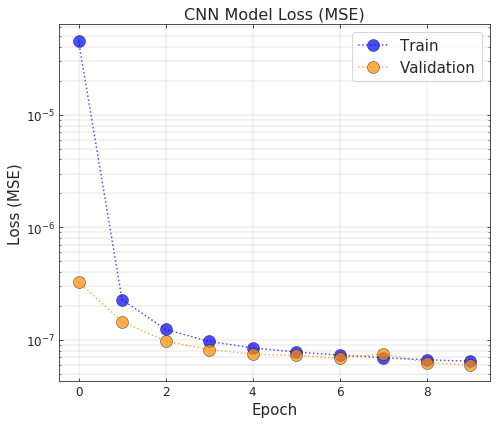

In [28]:
#model accuracy and loss
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(cnn_1D_history.history['loss'], marker='o', color='blue', markersize=12, markeredgecolor='k',markeredgewidth=0.5, linestyle=':', alpha=0.7)
ax.plot(cnn_1D_history.history['val_loss'], marker='o', color='darkorange', markersize=12, markeredgecolor='k',markeredgewidth=0.5, linestyle=':', alpha=0.7)
ax.set_ylabel('Loss (MSE)')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
#ax.set_ylim(0.0000001, 0.0001)
#ax.set_xlim(-0.1, 9.5)
ax.grid(b=True, which='both', axis='both', color='k', linestyle='-', linewidth=0.1)
ax.legend(['Train', 'Validation'], loc='upper right', prop={'size':15}, facecolor='white')
ax.set_title('CNN Model Loss (MSE)', size=16)

#plt.savefig(cwd + '/figures/CNN_loss.png')
plt.tight_layout()
plt.show()

### Prediction

In [30]:
def apply_model(df_test, model, cnn=False):
    """ Apply model and output a dataframe with RUL predictions.
    
    :param df_test: Input test dataframe.
    :param model: Model used to generate RUL predictions.
    :param cnn: True/False, reshape for input to CNN.
    :return: Dataframe with RUL predictions.
    """
    
    df_output = df_test.loc[:, ['RUL_pw', 'delta_RUL']] # save for df output
    df_test = df_test.drop(columns=['failure', 'RUL_pw', 'delta_RUL'], axis=1) # remove before prediction
    df_test = df_test.drop(columns=to_drop) # feature reduction
        
    RUL_preds = []
    delta_preds = []    
        
    for serial_num, inner_df in df_test.groupby(level=0):
        previous_day_RUL = inner_df.RUL_yesterday[0] # save the RUL of the first day of HDs life
        inner_df = inner_df.drop(columns='RUL_yesterday', axis=1) # remove RUL_yesterday for model to make predictions
        
        for i, row in inner_df.iterrows():
            Xtest = np.append(row.values, previous_day_RUL) # give model the previous_day_RUL
            if cnn == True:
                Xtest = Xtest.reshape(1, 11, 1) # reshape for 1D CNN input
            else:
                Xtest = Xtest.reshape(1, 11)
            
            delta = model.predict(Xtest) # model predicts the change in RUL
            previous_day_RUL = previous_day_RUL + delta # update previous_day_RUL with newly predicted value
            RUL_preds.append(previous_day_RUL) # save predicted RUL
            delta_preds.append(delta) # save predicted change in RUL
    
    RUL_preds = [item for array in RUL_preds for item in array]
    delta_preds = [item for array in delta_preds for item in array]

    df_output['RUL_pred'] = RUL_preds
    df_output['delta_RUL_pred'] = delta_preds
    
    df_output = df_output * RUL_cap # convert to days
    
    return df_output
    

In [31]:
def reg_report(df):
    """ Print regression evaluation report.
    
    :param df: Input dataframe from output from model.
    
    """ 
    
    # R2 score and RMSE on the RUL
    print('RUL R2 score: {}'.format(round(r2_score(df.RUL_pw, df.RUL_pred), 2)))
    print('RUL RMSE: {}'.format(round(np.sqrt(mean_squared_error(df.RUL_pw, df.RUL_pred)), 2)))
    
    # R2 score and RMSE on the delta RUL
    print('Delta RUL R2 score: {}'.format(round(r2_score(df.delta_RUL, df.delta_RUL_pred), 2)))
    print('Delta RUL RMSE: {}'.format(round(np.sqrt(mean_squared_error(df.delta_RUL, df.delta_RUL_pred)), 2)))
    

#### Assess Models

In [33]:
df_output_rfr = apply_model(model=rfr_opt, df_test=df_test)
df_output_gbr = apply_model(model=gbr_opt, df_test=df_test)
#df_output_cnn = apply_model(model=cnn_1D, df_test=df_test, cnn=True)

print('Regression Report: RFR')
reg_report(df_output_rfr)
print('---------------------------------------------------------- \n')
print('Regression Report: GBR')
reg_report(df_output_gbr)
print('---------------------------------------------------------- \n')
print('Regression Report: CNN')
reg_report(df_output_cnn)
print('---------------------------------------------------------- \n')


Regression Report: RFR
RUL R2 score: 0.98
RUL RMSE: 58.83
Delta RUL R2 score: 0.74
Delta RUL RMSE: 0.24
---------------------------------------------------------- 

Regression Report: GBR
RUL R2 score: 0.91
RUL RMSE: 125.06
Delta RUL R2 score: 0.1
Delta RUL RMSE: 0.45
---------------------------------------------------------- 

Regression Report: CNN
RUL R2 score: 0.99
RUL RMSE: 33.81
Delta RUL R2 score: 0.67
Delta RUL RMSE: 0.27
---------------------------------------------------------- 



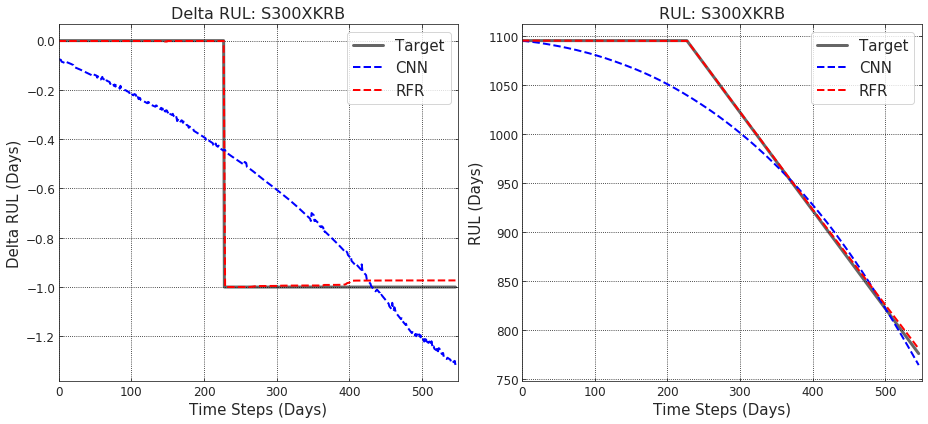

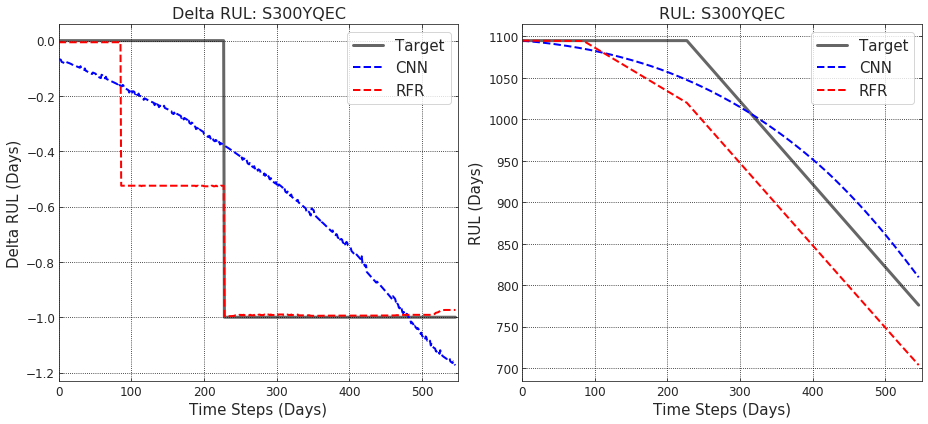

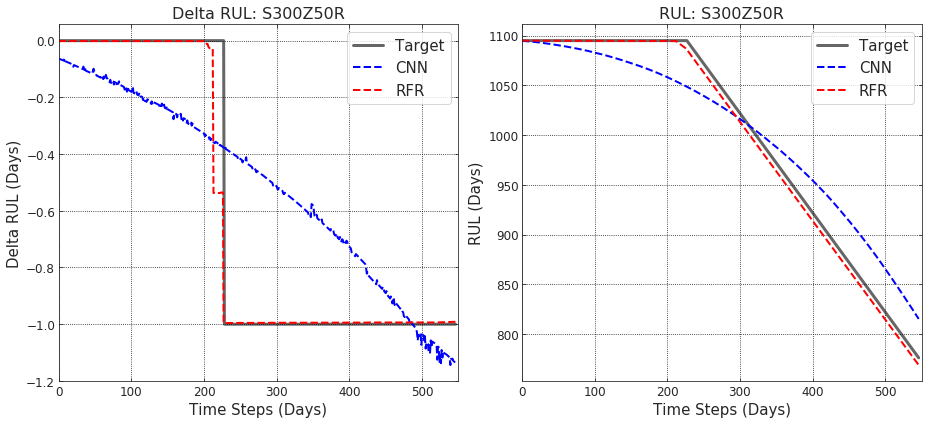

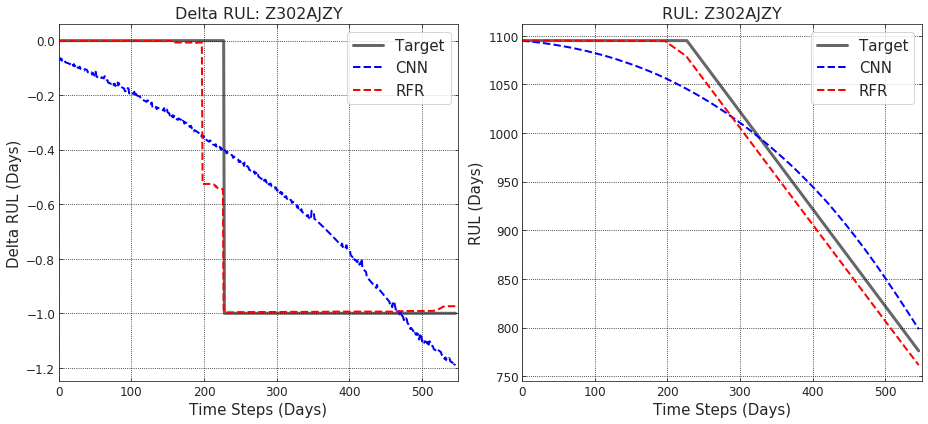

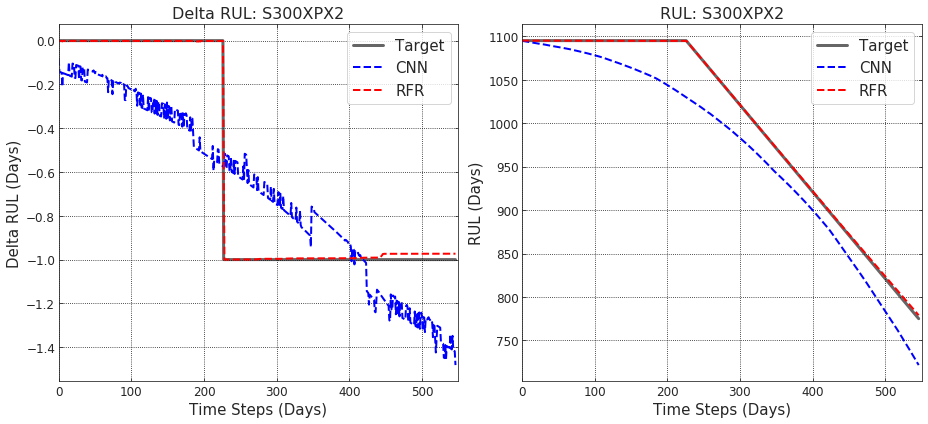

In [37]:
model_df = df_output_cnn

for hd in avg_not_failed:
    fig, ax = plt.subplots(1, 2, figsize=(13, 6))
    
    ax[0].plot(df_output_cnn.loc[hd].delta_RUL.values, color='k', linewidth=3, alpha=0.6)
    ax[0].plot(df_output_cnn.loc[hd].delta_RUL_pred.values, color='blue', linewidth=2, linestyle='--')
    ax[0].plot(df_output_rfr.loc[hd].delta_RUL_pred.values, color='red', linewidth=2, linestyle='--')    
    ax[0].set_xlim(0, 550)
    ax[0].set_xlabel('Time Steps (Days)')
    ax[0].set_ylabel('Delta RUL (Days)')
    ax[0].set_title('Delta RUL: ' + hd, size=16)
    ax[0].legend(['Target', 'CNN', 'RFR'], prop={'size':15})
    
    ax[1].plot(df_output_cnn.loc[hd].RUL_pw.values, color='k', linewidth=3, alpha=0.6)
    ax[1].plot(df_output_cnn.loc[hd].RUL_pred.values, color='blue', linewidth=2, linestyle='--')
    ax[1].plot(df_output_rfr.loc[hd].RUL_pred.values, color='red', linewidth=2, linestyle='--')
    ax[1].set_xlim(0, 550)
    #ax[1].set_ylim(0, 1200)
    ax[1].set_xlabel('Time Steps (Days)')
    ax[1].set_ylabel('RUL (Days)')
    ax[1].set_title('RUL: ' + hd, size=16)
    ax[1].legend(['Target', 'CNN', 'RFR'], prop={'size':15})
    
    #plt.savefig(cwd + '/figures/RUL_pred_{}.png'.format(hd))
    plt.tight_layout()
    plt.show()